# QAOA for the Max-Cut

In this section, we will solve the Maxcut Problem using QAOA with the help of the JijModeling and Qamomile libraries.

First, let’s install and import the main libraries we will be using.

In [1]:
import jijmodeling as jm
import ommx.v1
import matplotlib.pyplot as plt
import numpy as np

## What is the Max-Cut Problem

The Max-Cut problem is the problem of dividing the nodes of a graph into two groups such that the number of edges cut (or the total weight of the edges cut, if the edges have weights) is maximized. Applications include network partitioning and image processing (segmentation), among others.

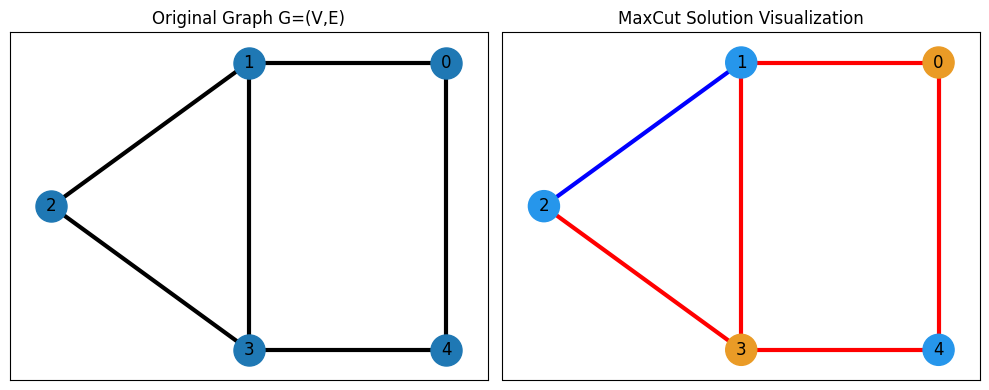

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}

cut_solution = {(1,): 1.0, (2,): 1.0, (4,): 1.0}
edge_colors = []


def get_edge_colors(
    graph, cut_solution, in_cut_color="r", not_in_cut_color="b"
) -> tuple[list[str], list[str]]:
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in G.nodes()]
    return edge_colors, node_colors


edge_colors, node_colors = get_edge_colors(G, cut_solution)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title("Original Graph G=(V,E)")
nx.draw_networkx(G, pos, ax=axes[0], node_size=500, width=3, with_labels=True)
axes[1].set_title("MaxCut Solution Visualization")
nx.draw_networkx(
    G,
    pos,
    ax=axes[1],
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)

plt.tight_layout()
plt.show()

## Constructing the Mathematical Model

The Max-Cut problem can be formulated with the following equation:

$$
  \max \quad \frac{1}{2} \sum_{(i,j) \in E} (1 - s_i s_j)  
$$

Note that this equation is expressed using Ising variables $ s \in \{ +1, -1 \} $. In this case, we want to formulate it using the binary variables $ x \in \{ 0, 1 \} $ from JijModeling. Therefore, we perform the conversion between Ising variables and binary variables using the following equations:

$$
    x_i = \frac{1 + s_i}{2} \quad \Rightarrow \quad s_i = 2x_i - 1
$$


In [3]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem


problem = Maxcut_problem()
problem

## Preparing Instance Data

Next, we will solve the Max-Cut Problem for the following graph. The data for the specific problem being solved is referred to as instance data.

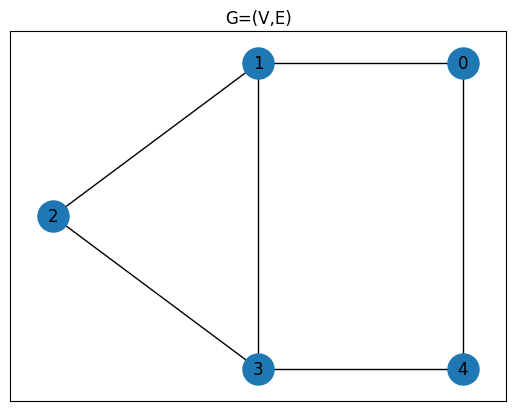

In [4]:
import networkx as nx
import numpy as np
from IPython.display import display, Latex

G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

weight_matrix = nx.to_numpy_array(G, nodelist=list(range(num_nodes)))

plt.title("G=(V,E)")
plt.plot(figsize=(5, 4))

nx.draw_networkx(G, pos, node_size=500)

In [5]:
V = num_nodes
E = edges

data = {"V": V, "E": E}

data

{'V': 5, 'E': [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]}

## Creating a Compiled Instance
We perform compilation using `JijModeling.Interpreter` and `ommx.Instance` by providing the formulation and the instance data prepared earlier. This process yields an intermediate representation of the problem with the instance data substituted.

In [8]:
interpreter = jm.Interpreter(data)
instance = interpreter.eval_problem(problem)

## Converting Compiled Instance to QAOA Circuit and Hamiltonian

We generate the QAOA circuit and Hamiltonian from the compiled Instance. The converter used to generate these is `qm.optimization.qaoa.QAOAConverter`.

By creating an instance of this class and using `ising_encode`, you can internally generate the Ising Hamiltonian from the compiled Instance. Parameters that arise during the conversion to QUBO can also be set here. If not set, default values are used.

Once the Ising Hamiltonian is generated, you can generate the QAOA quantum circuit and the Hamiltonian respectively. These can be executed using the `get_qaoa_ansatz` and `get_cost_hamiltonian` methods. The number of QAOA layers, $p$, is fixed to be $7$ here.  

In [20]:
import qamomile.circuit as qmc

@qmc.qkernel
def ising_cost(
    q: qmc.Vector[qmc.Qubit],
    edges: qmc.Matrix[qmc.UInt],  # (|E|, 2) matrix
    Jij: qmc.Vector[qmc.Float],  # (|E|,) vector
    hi: qmc.Vector[qmc.Float],  # (|V|,) vector,
    gamma: qmc.Float,
) -> qmc.Vector[qmc.Qubit]:
    num_e = edges.shape[0]
    for e in qmc.range(num_e):
        i = edges[e, 0]
        j = edges[e, 1]
        angle = 2 * Jij[e] * gamma
        q[i], q[j] = qmc.rzz(q[i], q[j], angle)
    n = hi.shape[0]
    for i in qmc.range(n):
        angle = 2 * hi[i] * gamma
        q[i] = qmc.rz(q[i], angle)
    return q


@qmc.qkernel
def x_mixer(
    q: qmc.Vector[qmc.Qubit],
    beta: qmc.Float,
) -> qmc.Vector[qmc.Qubit]:
    n = q.shape[0]
    for i in qmc.range(n):
        angle = 2 * beta
        q[i] = qmc.rx(q[i], angle)
    return q


@qmc.qkernel
def qaoa_state(
    edges: qmc.Matrix[qmc.UInt],  # (|E|, 2) matrix
    Jij: qmc.Vector[qmc.Float],  # (|E|,) vector
    hi: qmc.Vector[qmc.Float],  # (|V|,) vector,
    p: qmc.UInt,
    gammas: qmc.Vector[qmc.Float],  # (p,) vector
    betas: qmc.Vector[qmc.Float],  # (p,) vector
) -> qmc.Vector[qmc.Qubit]:
    n = hi.shape[0]
    q = qmc.qubit_array(n, name="qaoa_state")
    for iter in qmc.range(p):
        gamma = gammas[iter]
        beta = betas[iter]
        q = ising_cost(q, edges, Jij, hi, gamma)
        q = x_mixer(q, beta)
    return q

In [13]:
qubo, offset = instance.to_qubo()

In [15]:
from qamomile.core.ising_qubo import IsingModel


ising = IsingModel.from_qubo(qubo)

In [17]:
edges = []
Jij = []
hi = []

for indices, value in ising.coefficients.items():
    if len(indices) == 2:
        edges.append((indices[0], indices[1]))
        Jij.append(value)
    elif len(indices) == 1:
        hi.append((indices[0], value))

In [18]:
import qamomile.circuit as qmc

@qmc.qkernel
def qaoa(
    edges: qmc.Matrix[qmc.UInt],
    Jij: qmc.Vector[qmc.Float],
    hi: qmc.Vector[qmc.Float],
    p: qmc.UInt,
    gammas: qmc.Vector[qmc.Float],
    betas: qmc.Vector[qmc.Float],
) -> qmc.Vector[qmc.Bit]:
    q = qaoa_state(edges, Jij, hi, p, gammas, betas)
    return qmc.measure(q)

In [19]:
from qamomile.qiskit.transpiler import QiskitTranspiler

transpiler = QiskitTranspiler()
executor = transpiler.transpile(qaoa, bindings={"edges": edges, "Jij": Jij, "hi": hi, "p": 2}, parameters=["betas", "gammas"])

RuntimeError: Failed to resolve qubit indices for gate RZZ. Operands: ['q[edges[e,0]]', 'q[edges[e,1]]'].